# 批量规范化
:label:`sec_batch_norm`

训练深度神经网络是困难的。
让它们在合理的时间内收敛可能很棘手。
在本节中，我们描述了*批量规范化*，这是一种流行且有效的技术，
它始终能加速深层网络的收敛 :cite:`Ioffe.Szegedy.2015`。
与稍后在 :numref:`sec_resnet` 中介绍的残差块一起，
批量规范化使得实践者能够常规地训练超过100层的网络。
批量规范化的次要（意外的）好处在于其固有的正则化作用。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## 训练深度网络

在处理数据时，我们经常在训练前进行预处理。
关于数据预处理的选择通常会对最终结果产生巨大影响。
回想一下我们应用多层感知机（MLPs）来预测房价（:numref:`sec_kaggle_house`）。
当我们处理真实数据时，
第一步是将输入特征标准化，使其
均值 $\boldsymbol{\mu} = 0$ 和单位方差 $\boldsymbol{\Sigma} = \boldsymbol{1}$ 跨多个观测值 :cite:`friedman1987exploratory`，经常重新缩放后者使得对角线为1，即 $\Sigma_{ii} = 1$。
另一种策略是将向量归一化到单位长度，可能每个观测值的均值也为零。
这对于空间传感器数据等工作得很好。这些预处理技术和许多其他技术，
有助于保持估计问题的良好控制。 
有关特征选择和提取的综述，请参阅 :citet:`guyon2008feature` 的文章，例如。
向量标准化还有一个很好的副作用，即限制作用于其上的函数的复杂性。例如，在支持向量机中的著名半径-边界定理 :cite:`Vapnik95` 和感知器收敛定理 :cite:`Novikoff62` 都依赖于有界范数的输入。

直观上讲，这种标准化与我们的优化器很好地配合，
因为它使参数*先验*处于相似的尺度上。
因此，很自然地会问，一个深度网络*内部*的相应规范化步骤是否不会有益。
虽然这并不是导致批量规范化发明的原因 :cite:`Ioffe.Szegedy.2015`，但它是理解它及其表亲层规范化 :cite:`Ba.Kiros.Hinton.2016` 的一种有用的方式。

其次，对于典型的多层感知机或卷积神经网络，在训练过程中，
中间层的变量（例如，多层感知机中的仿射变换输出）
可能会取具有广泛不同幅度的值：
无论是从输入到输出的各层之间，同一层内的单元之间，
还是由于我们对模型参数的更新而随时间变化。
批量规范化的发明者非正式地假设
这种变量分布的漂移可能会阻碍网络的收敛。
直观上，我们可以推测，如果一层的激活值是另一层的100倍，
这可能需要对学习率进行补偿性调整。自适应求解器
如AdaGrad :cite:`Duchi.Hazan.Singer.2011`，Adam :cite:`Kingma.Ba.2014`，Yogi :cite:`Zaheer.Reddi.Sachan.ea.2018` 或分布式Shampoo :cite:`anil2020scalable` 旨在从优化的角度解决这个问题，例如通过添加二阶方法的方面。
另一种选择是通过自适应规范化防止问题发生。

第三，更深的网络更复杂，更容易过拟合。
这意味着正则化变得更加关键。正则化的一种常见技术是噪声注入。
这一点已经为人所知很长时间了，例如，关于输入噪声注入 :cite:`Bishop.1995`。它也是 :numref:`sec_dropout` 中Dropout的基础。事实证明，批量规范化意外地带来了所有三个好处：预处理、数值稳定性和正则化。

批量规范化应用于单个层，或者可选地应用于所有层：
在每次训练迭代中，
我们首先通过减去它们的均值并
除以它们的标准差来规范化输入（批量规范化的输入），
这两者都是基于当前小批量的统计数据估计的。
接下来，我们应用一个比例系数和一个偏移量来恢复失去的自由度。正是由于这种基于*批量*统计的*规范化*，
*批量规范化*得名。

请注意，如果我们试图用大小为1的小批量应用批量规范化，
我们将无法学到任何东西。
这是因为减去均值后，
每个隐藏单元的值都将为0。
正如你可能猜到的那样，既然我们专门用一整节来讨论批量规范化，
那么当使用足够大的小批量时，这种方法被证明是有效且稳定的。
这里的一个收获是，在应用批量规范化时，
批量大小的选择
比没有批量规范化时更加重要，或者至少，
需要适当的校准，因为我们可能需要调整批量大小。

设$\mathcal{B}$为一个小批量，让$\mathbf{x} \in \mathcal{B}$为
批量规范化（$\textrm{BN}$）的输入。在这种情况下，批量规范化定义如下：

$$\textrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta}.$$
:eqlabel:`eq_batchnorm`

在 :eqref:`eq_batchnorm` 中，
$\hat{\boldsymbol{\mu}}_\mathcal{B}$ 是小批量 $\mathcal{B}$ 的样本均值，
$\hat{\boldsymbol{\sigma}}_\mathcal{B}$ 是小批量 $\mathcal{B}$ 的样本标准差。
经过标准化后，
得到的小批量
具有零均值和单位方差。
选择单位方差
（而不是其他某个神奇数字）是任意的。我们通过包含逐元素的
*比例参数* $\boldsymbol{\gamma}$ 和 *偏移参数* $\boldsymbol{\beta}$
来恢复这种自由度，它们与 $\mathbf{x}$ 具有相同的形状。两者都是需要作为模型训练的一部分学习的参数。

中间层的变量幅度在训练过程中不能发散，
因为批量规范化主动将其中心化并重新缩放到给定的均值和大小（通过 $\hat{\boldsymbol{\mu}}_\mathcal{B}$ 和 ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$）。
实际经验表明，正如在讨论特征重缩放时提到的，批量规范化似乎允许使用更具侵略性的学习率。
我们在 :eqref:`eq_batchnorm` 中计算 $\hat{\boldsymbol{\mu}}_\mathcal{B}$ 和 ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ 如下：

$$\hat{\boldsymbol{\mu}}_\mathcal{B} = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x}
\textrm{ and }
\hat{\boldsymbol{\sigma}}_\mathcal{B}^2 = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon.$$

注意，我们在方差估计中添加了一个小常数 $\epsilon > 0$
以确保我们永远不会尝试除以零，
即使在经验方差估计非常小或消失的情况下也是如此。
估计 $\hat{\boldsymbol{\mu}}_\mathcal{B}$ 和 ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ 通过使用均值和方差的噪声估计来抵消缩放问题。
你可能会认为这种噪声应该是一个问题。
相反，它实际上是有益的。

这在深度学习中是一个反复出现的主题。
出于尚未完全理论化的理由，
优化中的各种噪声源
往往会导致更快的训练和更少的过拟合：
这种变化似乎起到了正则化的作用。
:citet:`Teye.Azizpour.Smith.2018` 和 :citet:`Luo.Wang.Shao.ea.2018`
分别将批量规范化的性质与贝叶斯先验和惩罚联系起来。
特别是，这揭示了为什么批量规范化在小批量大小在50-100范围内的效果最好。
这种特定大小的小批量似乎每层注入了“适量”的噪声，既通过 $\hat{\boldsymbol{\sigma}}$ 在规模上，也通过 $\hat{\boldsymbol{\mu}}$ 在偏移上：较大的小批量由于更稳定的估计而较少正则化，而极小的小批量
由于高方差而破坏有用的信号。进一步探索这一方向，考虑替代类型的预处理和过滤可能还会导致其他有效的正则化类型。

固定一个训练好的模型，你可能会认为
我们更愿意使用整个数据集
来估计均值和方差。
一旦训练完成，为什么我们希望
同一张图像根据其所处的小批量不同而被分类不同？
在训练过程中，这种精确计算是不可行的
因为所有数据示例的中间变量
在每次更新模型时都会发生变化。
然而，一旦模型训练完成，
我们可以基于整个数据集计算每一层变量的均值和方差。
事实上，这是采用批量规范化模型的标准做法；
因此，批量规范化层在*训练模式*（通过小批量统计进行规范化）和*预测模式*（通过数据集统计进行规范化）下的行为不同。
在这种形式下，它们的行为类似于 :numref:`sec_dropout` 中的Dropout正则化，
其中噪声仅在训练期间注入。


## 批量规范化层

全连接层和卷积层的批量规范化实现略有不同。
批量规范化与其他层的一个关键区别在于，
前者一次操作整个小批量，
我们不能像之前介绍其他层时那样忽略批量维度。

### 全连接层

当将批量规范化应用于全连接层时，
:citet:`Ioffe.Szegedy.2015` 在他们的原始论文中将批量规范化插入到仿射变换之后
和非线性激活函数*之前*。后来的应用实验了
将批量规范化插入到激活函数*之后*。
设全连接层的输入为 $\mathbf{x}$，
仿射变换
为 $\mathbf{W}\mathbf{x} + \mathbf{b}$（权重参数 $\mathbf{W}$ 和偏置参数 $\mathbf{b}$），
激活函数为 $\phi$，
我们可以将带有批量规范化的全连接层输出 $\mathbf{h}$ 表达为：

$$\mathbf{h} = \phi(\textrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) ).$$

请记住，均值和方差是在
*相同*的小批量
上计算的，该小批量也用于应用变换。

### 卷积层

类似地，对于卷积层，
我们可以在卷积之后但在非线性激活函数之前应用批量规范化。与全连接层中的批量规范化的关键区别在于，
我们按通道对所有位置进行操作。
这与导致卷积的平移不变性假设是一致的：我们假设图案在图像中的具体位置对于理解并不重要。

假设我们的小批量包含 $m$ 个样本
并且对于每个通道，
卷积的输出高度为 $p$，宽度为 $q$。
对于卷积层，我们对每个输出通道的 $m \cdot p \cdot q$ 个元素同时进行批量规范化。
因此，我们在计算均值和方差时收集所有空间位置的值，
从而
在同一通道内
对每个空间位置的值应用相同的均值和方差。
每个通道都有自己的比例和偏移参数，
这两个参数都是标量。

### 层规范化
:label:`subsec_layer-normalization-in-bn`

请注意，在卷积的背景下，即使对于大小为1的小批量，批量规范化也是明确的：毕竟，我们可以在整个图像的所有位置上进行平均。因此，
即使只在一个观测值内，均值和方差也是明确的。这一考虑
促使 :citet:`Ba.Kiros.Hinton.2016` 引入了*层规范化*的概念。它的运作方式与
批量规范化相同，只是每次只应用于一个观测值。因此，偏移量和缩放因子都是标量。对于 $n$ 维向量 $\mathbf{x}$，层规范化表示为 

$$\mathbf{x} \rightarrow \textrm{LN}(\mathbf{x}) =  \frac{\mathbf{x} - \hat{\mu}}{\hat\sigma},$$

其中，缩放和偏移按系数应用
并由以下公式给出

$$\hat{\mu} \stackrel{\textrm{def}}{=} \frac{1}{n} \sum_{i=1}^n x_i \textrm{ and }
\hat{\sigma}^2 \stackrel{\textrm{def}}{=} \frac{1}{n} \sum_{i=1}^n (x_i - \hat{\mu})^2 + \epsilon.$$

与之前一样，我们添加了一个小偏移量 $\epsilon > 0$ 以防止除以零。使用层规范化的主要优点之一是它可以防止发散。毕竟，忽略 $\epsilon$，层规范化的输出是独立于尺度的。也就是说，我们有 $\textrm{LN}(\mathbf{x}) \approx \textrm{LN}(\alpha \mathbf{x})$ 对于任何 $\alpha \neq 0$ 的选择。当 $|\alpha| \to \infty$ 时，这成为一个等式（近似等式是由于方差的偏移 $\epsilon$）。

层规范化的另一个优点是它不依赖于小批量的大小。它也不依赖于我们是在训练还是测试模式。换句话说，它只是一个确定性的转换，将激活标准化到给定的尺度。这在防止优化中的发散方面非常有益。我们省略进一步的细节，并建议感兴趣的读者查阅原文。

### 预测时的批量规范化

正如我们前面提到的，批量规范化在训练模式和预测模式下的行为通常是不同的。
首先，从小批量中估计样本均值和样本方差所产生的噪声
在训练完模型后就不再理想了。
其次，我们可能没有计算每批规范化统计量的奢侈条件。
例如，
我们可能需要一次应用模型进行一次预测。

通常，在训练后，我们使用整个数据集
来计算变量统计量的稳定估计
并在预测时将其固定。
因此，批量规范化在训练时和测试时的行为不同。
回想一下，Dropout也表现出这种特性。

## (**从零开始实现**)

为了看看批量规范化在实践中是如何工作的，我们在下面从零开始实现一个。

In [2]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

我们现在可以[**创建一个合适的`BatchNorm`层。**]
我们的层将维护适当的参数
用于缩放`gamma`和平移`beta`，
这两个参数都将在训练过程中进行更新。
此外，我们的层还将维护
均值和方差的移动平均值
以便在模型预测时使用。

抛开算法细节不谈，
请注意我们实现该层所依据的设计模式。
通常，我们在一个单独的函数中定义数学运算，比如说`batch_norm`。
然后我们将此功能集成到一个自定义层中，
该层的代码主要处理簿记事务，
例如将数据移到正确的设备上下文中，
分配和初始化任何所需的变量，
跟踪移动平均值（此处为均值和方差）等。
这种模式使得数学运算与样板代码得以清晰分离。
还要注意，为了方便起见
我们没有担心自动推断输入形状的问题；
因此我们需要在整个过程中指定特征数量。
现在所有现代深度学习框架都在高级批量归一化API中提供了自动检测大小和形状的功能（实践中我们会使用这个）。

In [3]:
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

我们使用了`momentum`来控制对过去均值和方差估计的聚合。这有点用词不当，因为它与优化中的*动量*术语完全没有关系。尽管如此，这是这个术语常用的名称，并且出于对API命名约定的尊重，我们在代码中使用了相同的变量名。

## [**带有批量归一化的LeNet**]

为了了解如何在实际中应用`BatchNorm`，
下面我们将其应用于传统的LeNet模型（:numref:`sec_lenet`）。
回想一下，批量归一化是在卷积层或全连接层之后
但在相应的激活函数之前应用的。

In [4]:
class BNLeNetScratch(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), BatchNorm(6, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120),
            BatchNorm(120, num_dims=2), nn.Sigmoid(), nn.LazyLinear(84),
            BatchNorm(84, num_dims=2), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

正如之前，我们将[**在Fashion-MNIST数据集上训练我们的网络**]。这段代码与我们首次训练LeNet时几乎完全相同。

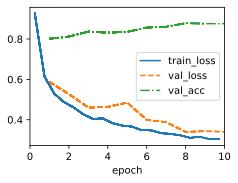

In [5]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNetScratch(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

让我们来看看从第一个批次归一化层学到的尺度参数`gamma`和偏移参数`beta`。

In [6]:
model.net[1].gamma.reshape((-1,)), model.net[1].beta.reshape((-1,))

(tensor([1.4334, 1.9905, 1.8584, 2.0740, 2.0522, 1.8877], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([ 0.7354, -1.3538, -0.2567, -0.9991, -0.3028,  1.3125], device='cuda:0',
        grad_fn=<ViewBackward0>))

## [**简洁实现**]

与我们刚刚自己定义的`BatchNorm`类相比，我们可以直接使用深度学习框架高级API中定义的`BatchNorm`类。除了不再需要提供额外的参数来使其维度正确外，代码看起来几乎相同。

In [7]:
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))

下面，我们[**使用相同的超参数来训练我们的模型。**]
请注意，像往常一样，高级API版本运行得快得多
因为它的代码已经被编译成C++或CUDA，
而我们自定义的实现必须由Python解释执行。

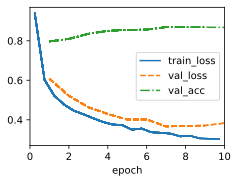

In [8]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## 讨论

直观上，批量归一化被认为可以使优化景观更平滑。然而，我们必须小心区分推测性的直觉和我们训练深度模型时观察到的现象的真实解释。回想一下，我们甚至不知道为什么更简单的深度神经网络（多层感知机和传统的卷积神经网络）一开始就能很好地泛化。即使有dropout和权重衰减，它们仍然如此灵活，以至于它们对未见过的数据的泛化能力可能需要显著更精细的学习理论泛化保证。

提出批量归一化的原始论文 :cite:`Ioffe.Szegedy.2015` 除了介绍一个强大且有用的工具外，还提供了解释其工作原理的原因：通过减少*内部协变量偏移*。大概他们所说的*内部协变量偏移*指的是上述直觉——即变量值分布随训练过程变化的概念。然而，这个解释存在两个问题：i) 这种漂移与*协变量偏移*非常不同，使得名称成为误称。如果有的话，它更接近于概念漂移。ii) 解释提供了一个不充分定义的直觉，但留下了*这种技术为何精确地起作用*的问题，等待一个严谨的解释。在本书中，我们旨在传达从业者用来指导其开发深度神经网络的直觉。然而，我们认为将这些指导性直觉与已确立的科学事实区分开来是很重要的。最终，当你掌握这些材料并开始撰写自己的研究论文时，你会希望清楚地区分技术主张和直觉。

随着批量归一化的成功，基于*内部协变量偏移*的解释在技术文献中的辩论以及关于如何呈现机器学习研究的更广泛讨论中反复出现。在2017年NeurIPS会议上接受时间考验奖时发表的一次难忘演讲中，Ali Rahimi用*内部协变量偏移*作为焦点，在一个将现代深度学习实践比作炼金术的论点中。随后，在概述机器学习中令人担忧的趋势的位置文件中详细回顾了这一例子 :cite:`Lipton.Steinhardt.2018`。其他作者提出了批量归一化成功的替代解释，有些 :cite:`Santurkar.Tsipras.Ilyas.ea.2018` 声称批量归一化的成功是因为表现出与原论文所声称的行为在某些方面相反。

我们注意到，*内部协变量偏移*并不比每年在技术机器学习文献中提出的数千个类似的模糊声明更值得批评。很可能，它之所以成为这些辩论的焦点，是由于它对于目标受众具有广泛的可识别性。批量归一化已被证明是一种不可或缺的方法，几乎应用于所有部署的图像分类器中，为引入该技术的论文赢得了数万次引用。尽管如此，我们推测，通过噪声注入进行正则化、通过重缩放加速以及最后预处理的指导原则可能会在未来导致更多层和技术的发明。

从更实际的角度来看，关于批量归一化有几个方面值得记住：

* 在模型训练过程中，批量归一化通过利用小批次的均值和标准差不断调整网络的中间输出，从而使整个神经网络各层的中间输出值更加稳定。
* 对于全连接层而言，批量归一化与卷积层略有不同。实际上，对于卷积层，有时可以使用层归一化作为替代方案。
* 类似于dropout层，批量归一化层在训练模式下的行为与预测模式下不同。
* 批量归一化有助于正则化和优化收敛。相比之下，减少内部协变量偏移的最初动机似乎不是一个有效的解释。
* 对于对输入扰动不太敏感的更健壮的模型，请考虑移除批量归一化 :cite:`wang2022removing`。

## 练习

1. 我们应该在批量归一化之前从全连接层或卷积层中移除偏差参数吗？为什么？
1. 比较有和没有批量归一化的LeNet的学习率。
    1. 绘制验证准确率的增长情况。
    1. 在两种情况下，你能把学习率提高到多大才会导致优化失败？
1. 我们是否需要在每一层都使用批量归一化？对此进行实验。
1. 实现一个仅去除均值的“轻量版”批量归一化，或者另一个只去除方差的版本。它的表现如何？
1. 固定参数`beta`和`gamma`。观察并分析结果。
1. 你可以用批量归一化替换dropout吗？行为会发生什么变化？
1. 研究思路：思考可以应用的其他归一化变换：
    1. 你能应用概率积分变换吗？
    1. 你能使用满秩协方差估计吗？你为什么可能不应该这样做？
    1. 你能使用其他紧凑矩阵变体（块对角、低位移秩、Monarch等）吗？
    1. 稀疏化压缩是否起到正则化的作用？
    1. 是否还有其他投影（例如，凸锥、特定对称群变换）可以使用？

[讨论](https://discuss.d2l.ai/t/84)